In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.2.2 installed.
fastai version 2.0.16 installed.


In [3]:
from nbdev.showdoc import *
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.IMAGENETTE_320)
path.ls()

(#2) [Path('/root/.fastai/data/imagenette2-320/val'),Path('/root/.fastai/data/imagenette2-320/train')]

Create a label dictionary to label the target variables

In [5]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [6]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [7]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=label_func,
                   splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                   item_tfms=RandomResizedCrop(224, min_scale=0.35),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])

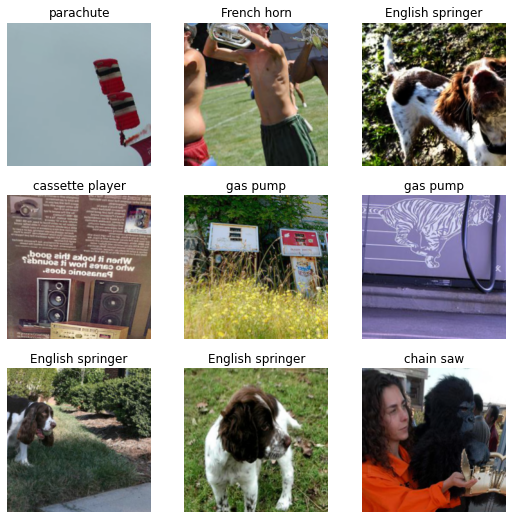

In [8]:
# Create a dataloaders object & display a small batch of samples
dls = dblock.dataloaders(path)
dls.show_batch()

Let's get one batch of data & check the shapes.
FastAI uses a default batchsize of 64

In [9]:
xb, yb = dls.one_batch()
print(f'Input shape: {xb.shape}, target shape: {yb.shape}.')

Input shape: torch.Size([64, 3, 224, 224]), target shape: torch.Size([64]).


Create the resnet model

In [10]:
## Input stem
conv_kwargs = {'kernel_size': 3, 'padding': 1, 'padding_mode': 'reflect', 'bias': False}

inp_stem = nn.Sequential(nn.Conv2d(3, 32, stride=2, **conv_kwargs),
                         nn.BatchNorm2d(32),
                         nn.ReLU(),
                         nn.Conv2d(32, 32, stride=1, **conv_kwargs),
                         nn.BatchNorm2d(32),
                         nn.ReLU(),
                         nn.Conv2d(32, 64, stride=1, **conv_kwargs),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                        )

In [11]:
## Resnet block
class ResNetBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.conv_path = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, stride=stride, **conv_kwargs),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            nn.Conv2d(ch_out, ch_out, stride=1, **conv_kwargs),
            nn.BatchNorm2d(ch_out)
           )
        self.id_path = []
        if ch_in != ch_out:
            # Use a Conv layer if the number of channels increase between the input & output.
            self.id_path.extend([nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, bias=False),
                                 nn.BatchNorm2d(ch_out)]
                               )
        if stride != 1:
            # Use AvgPooling if a stride is applied in the conv path.
            self.id_path = [nn.AvgPool2d(kernel_size=2, stride=2)] + self.id_path
        self.id_path = nn.Sequential(*self.id_path)

    def forward(self, xb):
        return nn.ReLU()(self.conv_path(xb) + self.id_path(xb))

In [12]:
# Resnet stages
stage1 = nn.Sequential(ResNetBlock(64, 64, stride=1),
                       ResNetBlock(64, 64, stride=1),
                       ResNetBlock(64, 64, stride=1)
                      )

stage2 = nn.Sequential(ResNetBlock(64, 128, stride=2),
                       ResNetBlock(128, 128, stride=1),
                       ResNetBlock(128, 128, stride=1),
                       ResNetBlock(128, 128, stride=1)
                      )

stage3 = nn.Sequential(ResNetBlock(128, 256, stride=2),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1)
                      )

stage4 = nn.Sequential(ResNetBlock(256, 512, stride=2),
                       ResNetBlock(512, 512, stride=1),
                       ResNetBlock(512, 512, stride=1)
                      )

In [13]:
# The complete model
myresnet34 = nn.Sequential(
                           inp_stem,
                           nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                           stage1,
                           stage2,
                           stage3,
                           stage4,
                           nn.AdaptiveAvgPool2d(1),
                           nn.Flatten(),
                           nn.Linear(512, 10)
                          )

We have slightly modified the kaiming_init function below from what was used in the previous article. The below function also supports nn.BatchNorm1d layers, which we will be using later in this article. I have also added a step to reset the weights for batchnorm layers, so that the function can be reused.

In [14]:
def kaiming_init(m):
    if getattr(m, 'bias', None) is not None:
        m.bias.data.zero_()
    if getattr(m, 'weight', None) is not None:
        if not isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            # BatchNorm layers are initialized with weight = 1. and bias=0. which is the reqd initialization for BatchNorm
            nn.init.kaiming_normal_(m.weight)
        else:
            m.weight.data.fill_(1.0)
    for l in m.children():
        kaiming_init(l)

In [15]:
# Move the model to GPU if available & initialize the weights & biases:
if torch.cuda.is_available():
    myresnet34.to(device = 'cuda')
kaiming_init(myresnet34)

Create a learner using our own model.

In [16]:
doc(Learner)

In [17]:
learn = Learner(dls, model=myresnet34)

In [18]:
# Loss function obtained from training dataset
dls.train_ds.loss_func

FlattenedLoss of CrossEntropyLoss()

In [19]:
# Default Callbacks
learn.cbs

(#3) [TrainEvalCallback,Recorder,ProgressCallback]

In [20]:
# Sorting order for Callbacks
sort_by_run(learn.cbs)

(#3) [TrainEvalCallback,Recorder,ProgressCallback]

Let's train the model for 1 epoch for a reference

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=1.5848931980144698e-06)

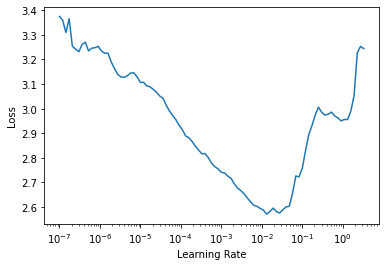

In [21]:
learn.lr_find()

In [22]:
# metrics are not added unless specified in the Learner constructor
learn.fit_one_cycle(1, lr=1e-3)

epoch,train_loss,valid_loss,time
0,1.657077,1.486185,04:10


In [23]:
doc(learn.fit)

In [24]:
# Displays the Eventtypes, Events and Callbacks during a fit operation.
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_

## Our Own LRFinder Callback

We want the lr finder callback to do the following:

* The lr finder should not disturb the weights initialization, hence the lr finder callback should first save the model parameters to a local file before the fit operation and should load it back at end of fit.
* The lr finder should run the fit for 100 iterations (batches) using exponentially increasing learning rates, so the lr finder callback should find the appropriate number of epochs to run the fit.
* Set up an exponentially increasing learning rate schedule.
* Cancel the training if the number of iterations > 100 or if the loss increases above 4 times the best loss obtained.
* Zero the gradients at the end of fit operation. 
* Create a plot of loss vs learning rate after the fit operation.



In [25]:
class MyLRFinder(Callback):
    """Custom Implementation of LR Finder callback"""
    run_after,run_valid = TrainEvalCallback,False

    def __init__(self, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
        self.scheds = {'lr': SchedExp(start_lr, end_lr)}
        self.num_it,self.stop_div = num_it,stop_div
  
    def before_fit(self):
        """Save the model to a local file to restore parameter weights at the end."""
        self.learn.save('_tmp')
        self.best_loss = float('inf')

    def _update_val(self, pct):
        """Update the parameter value in optimizer""" 
        for n,f in self.scheds.items(): self.opt.set_hyper(n, f(pct))
    
    def before_batch(self):
        """Update the hyper-parameters values in the optimizer"""
        self._update_val(self.train_iter/self.num_it)

    def after_batch(self):
        """Record hyper-parameters of this batch and potentially stop training"""
        if self.smooth_loss < self.best_loss: self.best_loss = self.smooth_loss
        if self.smooth_loss > 4*self.best_loss and self.stop_div: raise CancelFitException()
        if self.train_iter >= self.num_it: raise CancelFitException()

    def before_validate(self):
        """Skip the validation part of training"""
        raise CancelValidException()

    def after_fit(self):
        """Zero the gradients in the optimizer and restore the parameter weights to the values before lr_find call."""
        self.learn.opt.zero_grad() #Need to zero the gradients of the model before detaching the optimizer for future fits
        tmp_f = self.path/self.model_dir/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load('_tmp')
            os.remove(tmp_f)

Next, add a method to the Learner class to run our custom LRFinder callback

In [26]:
@patch
def my_lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb= MyLRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if show_plot: self.recorder.plot_lr_find()

Let's use our LRFinder now.

In [27]:
kaiming_init(myresnet34) # Reset model weights
learn = Learner(dls, model=myresnet34, metrics=accuracy)

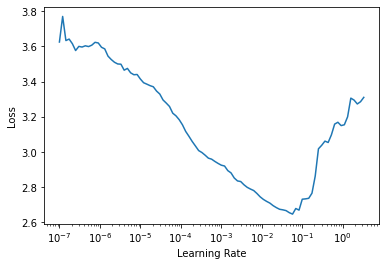

In [28]:
learn.my_lr_find()

## Transfer Learning on Pets dataset

In [29]:
# Create datablock for Pets
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=Pipeline([attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')]),
                 item_tfms=RandomResizedCrop(224, min_scale=0.35),
                 batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])

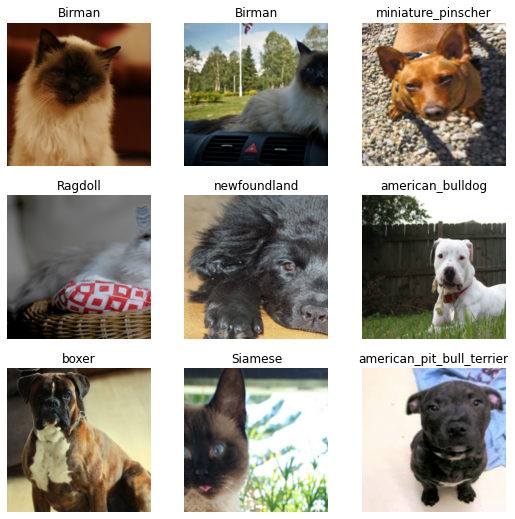

In [30]:
# Create dataloaders and show batch
source = untar_data(URLs.PETS)/"images"
pets_dls = pets.dataloaders(source)
pets_dls.show_batch(max_n=9)

In [31]:
# No of Target classes
pets_dls.c

37

Downloading the xresnet34 model pretrained on Imagenet data:

In [32]:
fastai_resnet = xresnet34(pretrained=True)
fastai_resnet

XResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

For a transfer learning setting, FastAI cuts the model at the pooling layer by default and replaces the head. Let's do the same.

In [33]:
pets_head = nn.Sequential(AdaptiveConcatPool2d(size=1),
                          Flatten(full=False),
                          nn.BatchNorm1d(1024),
                          nn.Dropout(p = 0.25, inplace=False),
                          nn.Linear(in_features=1024, out_features=512, bias=False),
                          nn.ReLU(inplace=True),
                          nn.BatchNorm1d(512),
                          nn.Dropout(p = 0.5, inplace=False),
                          nn.Linear(in_features=512, out_features=37, bias=False))

In [34]:
print(f'No. of parameters in pets_head: {len(list(pets_head.parameters()))}.')

No. of parameters in pets_head: 6.


In [35]:
# Initialize the head:
# Note that we are not altering the pretrained part of the model here.
kaiming_init(pets_head)

In [36]:
pets_resnet34 = nn.Sequential(*list(fastai_resnet.children())[:-4], pets_head)

In [37]:
# Move the model to GPU if available:
if torch.cuda.is_available():
    pets_resnet34.to(device = 'cuda')

In [38]:
pets_resnet34

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [39]:
len(list(pets_head.parameters()))

6

In [40]:
def custom_splitter(m, **kwargs):
    params = list(m.parameters())
    return [params[:-6], params[-6:]]

In [41]:
pets_learn = Learner(pets_dls, splitter=custom_splitter, model=pets_resnet34, metrics=accuracy)

In [42]:
pets_learn.opt is None

True

In [43]:
pets_learn.freeze()

In [44]:
## Calling the freeze() method creates the optimizer.
pets_learn.opt is None

False

In [45]:
params = [k for p in pets_learn.opt.param_lists[0] for k,v in pets_learn.model.named_parameters() if (v is p) and p.requires_grad]
print(f'No. of trainable params: {len(params)} in the first parameter group.')
print(f'\nTrainable parameters are: ')
', '.join(params)

No. of trainable params: 76 in the first parameter group.

Trainable parameters are: 


'0.1.weight, 0.1.bias, 1.1.weight, 1.1.bias, 2.1.weight, 2.1.bias, 4.0.convpath.0.1.weight, 4.0.convpath.0.1.bias, 4.0.convpath.1.1.weight, 4.0.convpath.1.1.bias, 4.1.convpath.0.1.weight, 4.1.convpath.0.1.bias, 4.1.convpath.1.1.weight, 4.1.convpath.1.1.bias, 4.2.convpath.0.1.weight, 4.2.convpath.0.1.bias, 4.2.convpath.1.1.weight, 4.2.convpath.1.1.bias, 5.0.convpath.0.1.weight, 5.0.convpath.0.1.bias, 5.0.convpath.1.1.weight, 5.0.convpath.1.1.bias, 5.0.idpath.1.1.weight, 5.0.idpath.1.1.bias, 5.1.convpath.0.1.weight, 5.1.convpath.0.1.bias, 5.1.convpath.1.1.weight, 5.1.convpath.1.1.bias, 5.2.convpath.0.1.weight, 5.2.convpath.0.1.bias, 5.2.convpath.1.1.weight, 5.2.convpath.1.1.bias, 5.3.convpath.0.1.weight, 5.3.convpath.0.1.bias, 5.3.convpath.1.1.weight, 5.3.convpath.1.1.bias, 6.0.convpath.0.1.weight, 6.0.convpath.0.1.bias, 6.0.convpath.1.1.weight, 6.0.convpath.1.1.bias, 6.0.idpath.1.1.weight, 6.0.idpath.1.1.bias, 6.1.convpath.0.1.weight, 6.1.convpath.0.1.bias, 6.1.convpath.1.1.weight, 6.1.

In [46]:
params = [k for p in pets_learn.opt.param_lists[-1] for k,v in pets_learn.model.named_parameters() if (v is p)]
print(f'No. of params: {len(params)} in the second parameter group.')
print(f'\nTrainable parameters are: ')
', '.join(params)

No. of params: 6 in the second parameter group.

Trainable parameters are: 


'8.2.weight, 8.2.bias, 8.4.weight, 8.6.weight, 8.6.bias, 8.8.weight'

In [47]:
print(len(trainable_params(pets_learn.model)))

82


In [48]:
print(len([p for p in pets_learn.model.parameters() if p.requires_grad]))

82


Modify the Recorder callback to track lr for all parameter groups

In [49]:
@patch
def before_fit(self:Recorder):
    # Make self.lrs to be a list of L's for each parameter groups in self.learn.opt:
    #self.lrs, self.iters,self.losses,self.values = [],[],[],[]
    self.iters,self.losses,self.values = [],[],[]
    self.lrs = [L() for _ in self.learn.opt.hypers]
    names = self.metrics.attrgot('name')
    if self.train_metrics and self.valid_metrics:
        names = L('loss') + names
        names = names.map('train_{}') + names.map('valid_{}')
    elif self.valid_metrics: names = L('train_loss', 'valid_loss') + names
    else: names = L('train_loss') + names
    if self.add_time: names.append('time')
    self.metric_names = 'epoch'+names
    self.smooth_loss.reset()

In [50]:
@patch
def after_batch(self:Recorder):
    "Update all metrics and records lr and smooth loss in training"
    if len(self.yb) == 0: return
    mets = self._train_mets if self.training else self._valid_mets
    for met in mets: met.accumulate(self.learn)
    if not self.training: return
    #self.lrs.append(self.opt.hypers[-1]['lr'])
    for lr_list, hyper_dict in zip(self.lrs, self.opt.hypers):
        lr_list.append(hyper_dict['lr'])
    self.losses.append(self.smooth_loss.value)
    self.learn.smooth_loss = self.smooth_loss.value

In [51]:
def trim_axs(axs, N):
    """Helper function to remove unwanted axes"""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [52]:
@patch
def plot_lr_find(self:Recorder, skip_end=5):
    "Plot the result of an LR Finder test (won't work if you didn't do `learn.lr_find()` before)"
    lrs    = self.lrs    if skip_end==0 else [l_[:-skip_end] for l_ in self.lrs]
    losses = self.losses if skip_end==0 else self.losses[:-skip_end]
    nrows = 1 + len(lrs)//3
    ncols = 3 if len(lrs) > 3 else len(lrs)
    fig, axs = plt.subplots(nrows, ncols, figsize = (5*ncols, 5*nrows))
    axs = trim_axs(axs, len(lrs)) if len(lrs) >1 else [axs]
    for i, ax, lr in zip(range(len(lrs)), axs, lrs):
        ax.plot(lr, losses)
        ax.set_ylabel("Loss")
        ax.set_xlabel(f"Learning Rate for PG{i}")
        ax.set_xscale('log')
        ax.set_title(f"Parameter Group {i}")

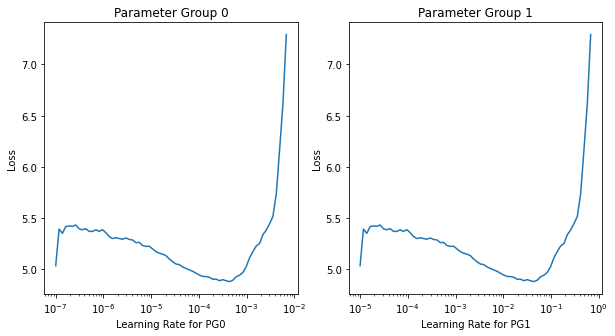

In [53]:
pets_learn.my_lr_find(start_lr=np.array([1e-7, 1e-5]), end_lr=np.array([1., 100.]))

Let's train our frozen model for 3 epochs.

In [54]:
pets_learn.fit_one_cycle(3, max_lr=np.array([5e-5, 5e-3]))

epoch,train_loss,valid_loss,accuracy,time
0,4.339747,3.717043,0.114344,01:41
1,3.687243,3.204037,0.160352,01:41
2,3.398793,3.107249,0.183356,01:40


Next unfreeze the entire model and train again.

In [55]:
pets_learn.unfreeze()

In [56]:
print(len(trainable_params(pets_learn.model)))

120


We will continue to train the head at 100x learning rate.

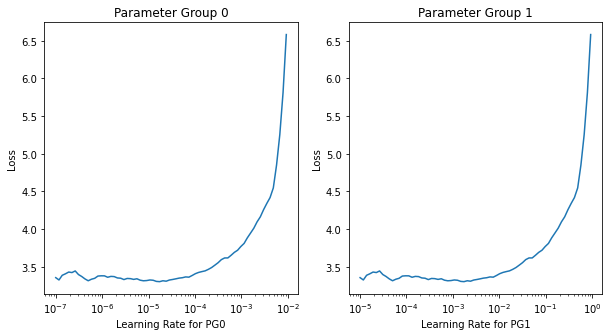

In [57]:
pets_learn.my_lr_find(start_lr=np.array([1e-7, 1e-5]), end_lr=np.array([1., 100.]))

In [58]:
pets_learn.fit_one_cycle(10, max_lr=np.array([5e-6, 5e-4]))

epoch,train_loss,valid_loss,accuracy,time
0,3.256733,3.112774,0.187415,02:19
1,3.111897,3.269919,0.205007,02:20
2,2.833279,2.736565,0.255751,02:18
3,2.406991,2.288841,0.348444,02:18
4,2.104872,2.289328,0.372124,02:18
5,1.831441,1.939585,0.437077,02:18
6,1.551044,1.796132,0.493911,02:18
7,1.388044,1.600852,0.529093,02:18
8,1.242730,1.348937,0.589986,02:18
9,1.213527,1.343609,0.590663,02:18
